In [104]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('dark_background')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

### Calculating the YSIGN feature from intersection peaks
This file continues exploration done in eda_intersection_volume, calculating the custom feature for our classifier.

Work performed:
- load data (intersection volumes and Bo's LTS data targets).
- code a function that propagates 'intersection yield' out to roads without signalized intersections.
- visualize new data relationships.

#### Imports:

In [2]:
# Import the intersection data
intersections = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/traffic-signal-vehicle-and-pedestrian-volumes-data.csv')

# convert to pandas dataframe using lat long and plot
intersections_gpd = gpd.GeoDataFrame(intersections, geometry=gpd.points_from_xy(intersections.Longitude, intersections.Latitude))

# remove the outlier
intersections_gpd = intersections_gpd.drop(index=2261)
intersections_gpd.crs = {'init': 'epsg:4326'}

# import Bo's shapefile
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')

# Drop the 0 LTS datapoint
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]

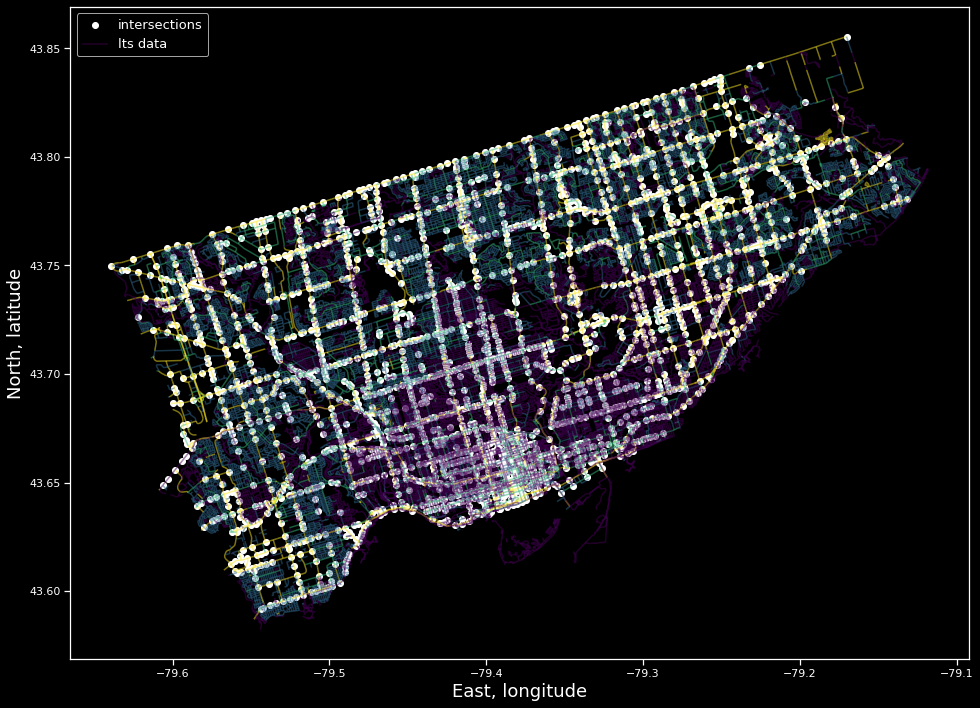

In [7]:
# Plot the two against each other. Either Bo's or the overall shapefile
ax = intersections_gpd.plot(figsize=(20, 12), label='intersections', color='white')
lts_gpd.plot(ax=ax, column='LTS', figsize=(20, 12), label='lts data', alpha=0.5)
# centrelines_cycling_gpd.plot(ax=ax, alpha=0.5, label='cycleable roads')
plt.xlabel('East, longitude', fontsize=18)
plt.ylabel('North, latitude', fontsize=18)
ax.grid(False)
plt.legend(prop={'size':13})

In [8]:
lts_gpd

,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,0.004459,"LINESTRING (-79.54478 43.58583, -79.54478 43.5..."
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,0.000426,"LINESTRING (-79.54478 43.58583, -79.54483 43.5..."
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,0.000375,"LINESTRING (-79.54454 43.58611, -79.54464 43.5..."
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,0.001771,"LINESTRING (-79.54454 43.58611, -79.54433 43.5..."
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,0.000892,"LINESTRING (-79.54386 43.58668, -79.54400 43.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...
59549,59550,30113298,78,Crescent Town Rd,30072815,30113297,0,42.363457,30113298,1,0.000412,"LINESTRING (-79.29186 43.69576, -79.29182 43.6..."
59550,59551,30113299,78,Crescent Town Rd,30113297,13458516,0,7.618206,30113299,1,0.000083,"LINESTRING (-79.29163 43.69610, -79.29157 43.6..."
59551,59552,30113300,11101,Crescent Pl,13458684,30113297,0,283.230612,30113300,1,0.003167,"LINESTRING (-79.29239 43.69527, -79.29232 43.6..."
59552,59553,30012613,558,Dundas St W,30012611,13467982,0,71.537178,30012613,4,0.000727,"LINESTRING (-79.53297 43.64414, -79.53346 43.6..."


In [9]:
intersections_gpd

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,geometry
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,06-21-2017,15662,13535,POINT (-79.37145 43.64942)
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,09-17-2016,12960,7333,POINT (-79.37192 43.65046)
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,11-08-2016,17770,7083,POINT (-79.37236 43.65153)
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,12-08-2015,19678,4369,POINT (-79.37282 43.65272)
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,09-17-2016,14487,3368,POINT (-79.37324 43.65370)
...,...,...,...,...,...,...,...,...,...,...,...,...
2275,3005,WINDERMERE AVE,NaN,MORNINGSIDE AVE,NaN,01/01/1967,43.644885,-79.478592,12-10-2009,6488,634,POINT (-79.47859 43.64489)
2276,3006,GATEWAY BLVD,NaN,GRENOBLE DR,NaN,05/28/1976,43.711967,-79.330476,05-02-2017,7447,1316,POINT (-79.33048 43.71197)
2277,3009,ALLIANCE AVE,NaN,ROCKCLIFFE BLVD,NaN,02/13/1969,43.676947,-79.489360,02-15-2018,8780,498,POINT (-79.48936 43.67695)
2278,3011,OLD FINCH AVE,250m EAST OF,SEWELLS RD,NaN,04/11/1974,43.825259,-79.196812,11-27-2008,1081,0,POINT (-79.19681 43.82526)


#### Write the function to join them and create the YSIGN feature
the function should loop until it covers every street (59553), unless some streets are isolated from others. This might be the case, so start by creating it in a for loop. <br>
##### we might want to drop "trails" as we already know these will automatically be 1 and they don't have vehicle traffic!

In [134]:
def create_ysign(intersections, lts, dropoff, iters):
    """
    This function iterates an algorith to assign 'YSIGN' to the roads in Toronto.
    YSIGN is a weighted measure of 'yield' for roads based on how close it is to
    a signalized intersection. The weight is given as the mean of connecting road
    values divided by a dropoff coefficient. The original weights come from the 8hr
    peak volume at signalized intersections in Toronto in the 21st century.
    
    intersections = intersections gpd dataframe,
    lts = lts gpd dataframe,
    dropoff = coefficient to divide volume by each iteration,
    iters = number of steps through.
    """
    
    # Convert to local metre crs.
    inter_metre = intersections_gpd.to_crs("EPSG:26917")
    lts_metre = lts_gpd.to_crs("EPSG:26917")
    
    # Set a buffer corresponding to lat lon count error; assume 5-10m?
    inter_metre['geometry'] = inter_metre.buffer(8) 
    inter_metre['intersects'] = 1
    
    # Do the initial merge
    initial_merge = gpd.sjoin(inter_metre, #left
                              lts_metre, #right
                              how='right',
                              op='intersects')

    initial_merge = initial_merge[initial_merge['intersects'] == 1]

    # Aggregate: the mean of 8 hr peaks (we might also want info on the connecting intersection index and dates).
    peaks = ['8 Peak Hr Vehicle Volume','8 Peak Hr Pedestrian Volume']
    merger = initial_merge[peaks].groupby(initial_merge.index).agg({'8 Peak Hr Vehicle Volume': 'mean',
                                                                    '8 Peak Hr Pedestrian Volume': 'mean'}
                                                                   )

    # Combine merger with the lts data.
    first_merge = pd.merge(left=lts_metre,
                           right=merger,
                           how='left',
                           left_index=True,
                           right_index=True,
                          )
    
    first_merge = first_merge.rename({'8 Peak Hr Vehicle Volume': 'ysign vehicle',
                                      '8 Peak Hr Pedestrian Volume': 'ysign ped'}, axis=1)
    
    # Do the rest of the merges in a loop: add ysign to the next proximal roads divided by the dropoff coefficient
    merge = first_merge
    for i in range(0,iters):
        
        # Print some info
        print('starting iteration: ', i)
        print('roads with ysign: ', merge[merge['ysign vehicle'].notnull()].shape[0])
        print('roads without: ', lts_metre.shape[0] - merge[merge['ysign vehicle'].notnull()].shape[0])
        print('\n')
        
        # Split, extract the null and non-null values
        not_null = merge[merge['ysign vehicle'].notnull()]
        volumes_not_null = not_null[['ysign vehicle','ysign ped','geometry']]
        volumes_not_null['intersects'] = 1

        null = merge[merge['ysign vehicle'].isnull()]
        volumes_null = null.drop(['ysign vehicle','ysign ped'], axis=1)
        
        # Merge and take only those that intersect
        ini_merge = gpd.sjoin(volumes_null, #left
                      volumes_not_null, #right
                      how='left',
                      op='intersects')
        
        ini_merge = ini_merge[ini_merge['intersects'] == 1]
        
        # groupby & agg mean peak volumes.
        # Use GEO_ID of the shape as it is retained through all the merging.
        # Divide values by dropoff coefficient to account for the step away
        peaks = ['GEO_ID', 'ysign vehicle','ysign ped']
        new_vols = ini_merge[peaks].groupby('GEO_ID').agg({'ysign vehicle': lambda x: np.mean(x) / dropoff,
                                                            'ysign ped': lambda x: np.mean(x) / dropoff}
                                                         )
        
        # merge new values with the rest of them.
        merge = pd.merge(left=merge,
                         right=new_vols,
                         how='left',
                         left_on='GEO_ID',
                         right_on='GEO_ID',
                        )
        
        # combine the ysign columns into one, drop the useless column, continue in the loop
        vol_cols = ['ysign ped_x', 'ysign ped_y', 'ysign vehicle_x', 'ysign vehicle_y']

        merge[vol_cols[0]] = merge[vol_cols[0]].fillna(merge[vol_cols[1]])
        merge[vol_cols[2]] = merge[vol_cols[2]].fillna(merge[vol_cols[3]])
        merge = merge.rename({'ysign vehicle_x': 'ysign vehicle', 'ysign ped_x': 'ysign ped'}, axis=1)

        # Drop uneeded vol_col
        merge = merge.drop([vol_cols[1],vol_cols[3]], axis=1)
        
        
    #Print a summary and return the desired df    
    print('final iteration: ', i)
    print('roads with ysign: ', merge[merge['ysign vehicle'].notnull()].shape[0])
    print('roads without: ', lts_metre.shape[0] - merge[merge['ysign vehicle'].notnull()].shape[0])
    print('\n')
    
    return merge
        
    
ysign = create_ysign(intersections_gpd, lts_gpd, 1.25, 15) 
ysign

starting iteration:  0
roads with ysign:  6713
roads without:  52840


starting iteration:  1
roads with ysign:  16709
roads without:  42844


starting iteration:  2
roads with ysign:  28487
roads without:  31066


starting iteration:  3
roads with ysign:  38965
roads without:  20588


starting iteration:  4
roads with ysign:  46730
roads without:  12823


starting iteration:  5
roads with ysign:  51594
roads without:  7959


starting iteration:  6
roads with ysign:  54623
roads without:  4930


starting iteration:  7
roads with ysign:  56399
roads without:  3154


starting iteration:  8
roads with ysign:  57489
roads without:  2064


starting iteration:  9
roads with ysign:  58161
roads without:  1392


starting iteration:  10
roads with ysign:  58597
roads without:  956


starting iteration:  11
roads with ysign:  58859
roads without:  694


starting iteration:  12
roads with ysign:  58998
roads without:  555


starting iteration:  13
roads with ysign:  59088
roads without:  465


st

,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,ysign vehicle,ysign ped
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,0.004459,"LINESTRING (617480.231 4826902.149, 617480.138...",1175.317801,30.064771
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,0.000426,"LINESTRING (617480.231 4826902.149, 617476.262...",1175.317801,30.064771
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,0.000375,"LINESTRING (617498.783 4826933.578, 617490.916...",1469.147251,37.580964
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,0.001771,"LINESTRING (617498.783 4826933.578, 617516.356...",1469.147251,37.580964
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,0.000892,"LINESTRING (617552.625 4826998.137, 617541.914...",1836.434063,46.976205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59548,59550,30113298,78,Crescent Town Rd,30072815,30113297,0,42.363457,30113298,1,0.000412,"LINESTRING (637647.674 4839500.121, 637650.815...",6337.280000,232.320000
59549,59551,30113299,78,Crescent Town Rd,30113297,13458516,0,7.618206,30113299,1,0.000083,"LINESTRING (637664.874 4839538.711, 637670.289...",7921.600000,290.400000
59550,59552,30113300,11101,Crescent Pl,13458684,30113297,0,283.230612,30113300,1,0.003167,"LINESTRING (637605.584 4839445.335, 637611.564...",5700.160000,144.000000
59551,59553,30012613,558,Dundas St W,30012611,13467982,0,71.537178,30012613,4,0.000727,"LINESTRING (618319.465 4833394.763, 618280.936...",9973.600000,916.000000


In [135]:
# Add a column that group based on LTS into high access or low access
ysign['high access'] = ysign['LTS'].apply(lambda x: 1 if x <= 2 else 0)

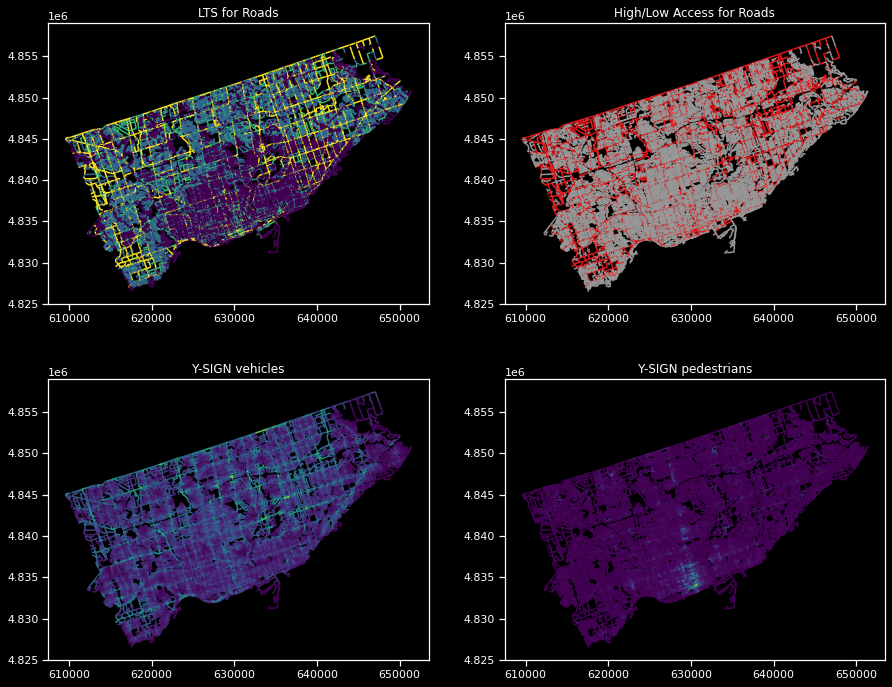

In [136]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Figure
fig, axs = plt.subplots(figsize=(15,12), ncols=2, nrows=2)

# Plotting
ysign[ysign['ysign vehicle'].notnull()].plot(ax=axs[0,0], column='LTS')
ysign[ysign['ysign vehicle'].notnull()].plot(ax=axs[0,1], column='high access', cmap='Set1')
ysign.plot(ax=axs[1,0], column='ysign vehicle')
ysign.plot(ax=axs[1,1], column='ysign ped')


# Attributes
axs[0,0].title.set_text('LTS for Roads')
axs[0,1].title.set_text('High/Low Access for Roads')
axs[1,0].title.set_text('Y-SIGN vehicles')
axs[1,1].title.set_text('Y-SIGN pedestrians')
axs[0,0].grid(False)
axs[0,1].grid(False)
axs[1,0].grid(False)                     
axs[1,1].grid(False)

plt.show()

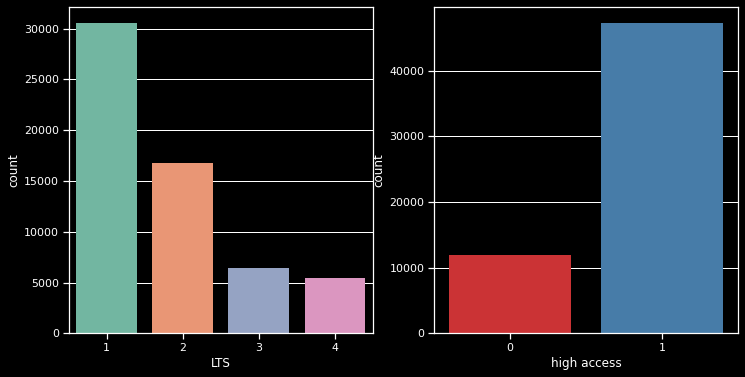

In [137]:
# Plot the class imbalance
# Now plot the class sizes with the remaining data.
fig, ax = plt.subplots(figsize=(12,6), ncols=2)
sns.countplot(ax=ax[0], data=ysign[ysign['ysign vehicle'].notnull()],
              x='LTS',
              palette='Set2')

sns.countplot(ax=ax[1], data=ysign[ysign['ysign vehicle'].notnull()],
              x='high access',
              palette='Set1')


plt.show()

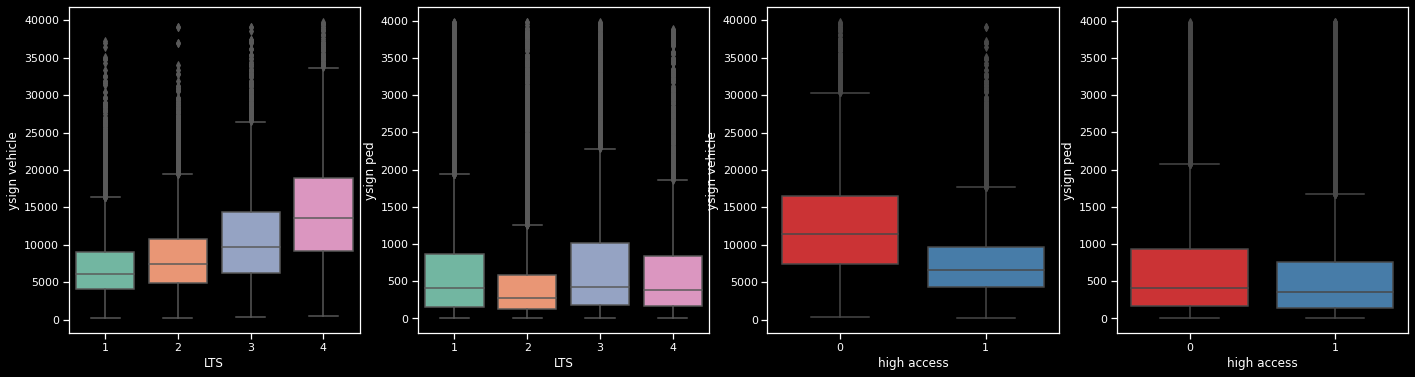

In [138]:
# Visualize using Box plots: we might have something here!
fig, ax = plt.subplots(figsize=(24,6), ncols=4, nrows=1)

sns.boxplot(data=ysign[(ysign['ysign ped'] < 4000) & 
                       (ysign['ysign vehicle'] < 40000)],
            x='LTS', y='ysign vehicle', palette='Set2', ax=ax[0]
           )

sns.boxplot(data=ysign[(ysign['ysign ped'] < 4000) & 
                       (ysign['ysign vehicle'] < 40000)],
            x='LTS', y='ysign ped', ax=ax[1], palette='Set2'
           )

sns.boxplot(data=ysign[(ysign['ysign ped'] < 4000) & 
                       (ysign['ysign vehicle'] < 40000)],
            x='high access', y='ysign vehicle', ax=ax[2], palette='Set1'
           )

sns.boxplot(data=ysign[(ysign['ysign ped'] < 4000) & 
                       (ysign['ysign vehicle'] < 40000)],
            x='high access', y='ysign ped', ax=ax[3], palette='Set1'
           )

ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)

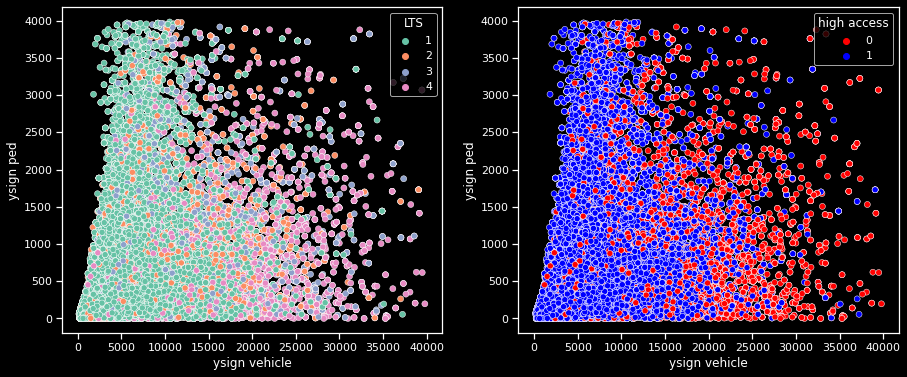

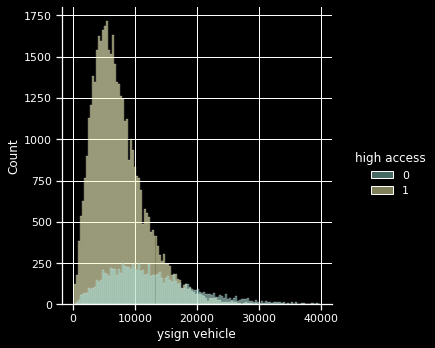

In [148]:
# We can visualize the two against each other
fig, ax = plt.subplots(ncols=2, figsize=(15,6))

# Isolate the segments for which we have volumes
sns.scatterplot(data=ysign[(ysign['ysign ped'] < 4000) & 
                                  (ysign['ysign vehicle'] < 40000)],
                x='ysign vehicle', y='ysign ped',
                hue='LTS', palette='Set2', ax=ax[0]
               )

sns.scatterplot(data=ysign[(ysign['ysign ped'] < 4000) & 
                                  (ysign['ysign vehicle'] < 40000)],
                x='ysign vehicle', y='ysign ped',
                hue='high access', ax=ax[1], palette=['red','blue']
               )

sns.displot(data=ysign[(ysign['ysign ped'] < 4000) & 
                                  (ysign['ysign vehicle'] < 40000)],
            x='ysign vehicle', hue='high access', fill=True)
#parameters
ax[0].grid(False)
ax[1].grid(False)

plt.show()

Save these created features to a csv that can be imported in a model

In [140]:
# There as some values that are very hard to converge to with our function, but it is very few so we can just drop them.
print(ysign.isnull().sum())
ysign = ysign.dropna()
ysign.isnull().sum()

OBJECTID           0
GEO_ID             0
LFN_ID             0
LF_NAME            0
FNODE              0
TNODE              0
ONE_WAY_DI         0
length_in_         0
GEO_ID_1           0
LTS                0
Shape_Leng         0
geometry           0
ysign vehicle    386
ysign ped        386
high access        0
dtype: int64


OBJECTID         0
GEO_ID           0
LFN_ID           0
LF_NAME          0
FNODE            0
TNODE            0
ONE_WAY_DI       0
length_in_       0
GEO_ID_1         0
LTS              0
Shape_Leng       0
geometry         0
ysign vehicle    0
ysign ped        0
high access      0
dtype: int64

In [141]:
# Do a 80/20 test train split and save these to a csv
from sklearn.model_selection import train_test_split

#stratify the split across the LTS labels
train, test = train_test_split(ysign, test_size=0.2, stratify=ysign['LTS'])
print('Train:', train.shape, 'Test:', val.shape)
print('LTS 1 Train proportion: {:.2f} %'.format(train['LTS'][train['LTS'] == 1].shape[0] / train.shape[0] * 100))
print('LTS 1 Test proportion: {:.2f} %'.format(val['LTS'][val['LTS'] == 1].shape[0] / val.shape[0] * 100))

Train: (47333, 15) Test: (11834, 15)
LTS 1 Train proportion: 51.68 %
LTS 1 Test proportion: 51.69 %


In [142]:
train.to_csv('ysign_dropoff125_iter15_train.csv')
test.to_csv('ysign_dropoff125_iter15_test.csv')